In [1]:
!pip install biopython numpy matplotlib hmmlearn ipywidgets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.1 MB/s eta 0:00:00


<ipython-input-19-e9e1f0d18d22>:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


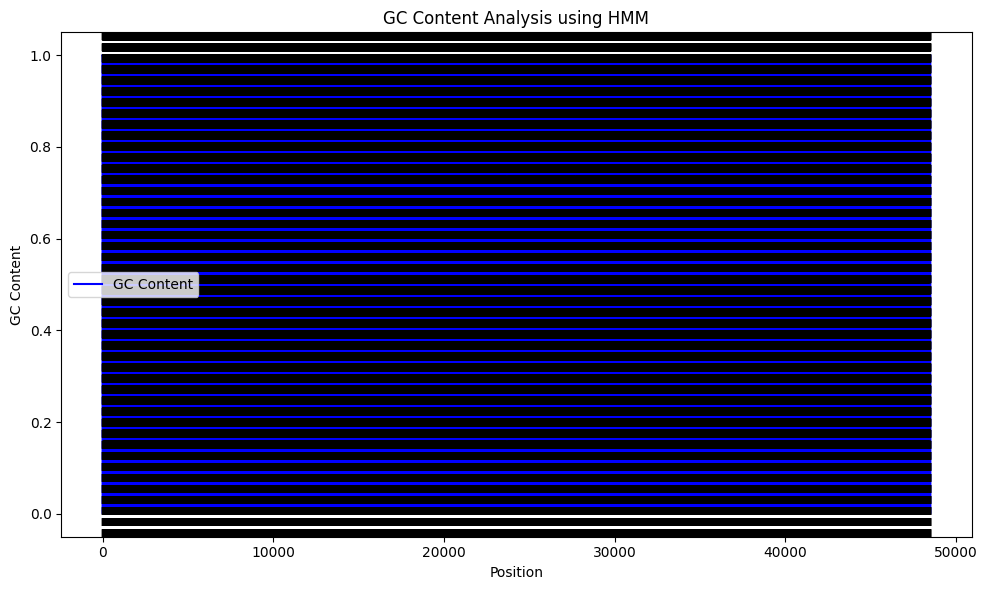

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from Bio import SeqIO
from hmmlearn.hmm import GaussianHMM

# Function to calculate GC content
def calculate_gc_content(sequence):
    gc_count = sequence.count('G') + sequence.count('C')
    total_count = len(sequence)
    gc_content = gc_count / total_count
    return gc_content

# Function to apply HMM and find change points
def apply_hmm(gc_contents):
    data = np.array(gc_contents).reshape(-1, 1)
    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(data)
    hidden_states = model.predict(data)
    return hidden_states

# Function to plot the results
def plot_results(gc_contents, hidden_states):
    plt.figure(figsize=(10, 6))

    # GC content plot
    plt.plot(gc_contents, label="GC Content", color="blue")

    # Change points plot
    for i, state in enumerate(hidden_states):
        if i > 0 and hidden_states[i] != hidden_states[i-1]:
            plt.axvline(x=i, color="black", linestyle="--")

    plt.title("GC Content Analysis using HMM")
    plt.xlabel("Position")
    plt.ylabel("GC Content")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Read the sequence from a FASTA file
def read_sequence_from_fasta(fasta_file_path):
    record = SeqIO.read(fasta_file_path, "fasta")
    sequence = str(record.seq)
    return sequence

# Main function
def main():
    fasta_file_path = "example_fasta_file.fasta"
    sequence = read_sequence_from_fasta(fasta_file_path)

    # Calculate GC content for each position
    gc_contents = [calculate_gc_content(sequence[i]) for i in range(len(sequence))]

    # Apply HMM and find change points
    hidden_states = apply_hmm(gc_contents)

    # Plot the results
    plot_results(gc_contents, hidden_states)

if __name__ == "__main__":
    main()


In [17]:
import collections
from Bio import SeqIO
from Bio.Seq import Seq
import ipywidgets as widgets
from IPython.display import display

# Function to read sequences from a FASTA file
def read_sequences_from_fasta(fasta_file_path):
    records = list(SeqIO.parse(fasta_file_path, "fasta"))
    sequences = []
    for record in records:
        sequences.append(str(record.seq))
    return sequences

# Function to calculate nucleotide densities
def calculate_nucleotide_densities(sequence, window_size):
    length = len(sequence)
    densities = {"A": [], "T": [], "C": [], "G": []}
    for i in range(0, length - window_size + 1, window_size):
        window = sequence[i:i + window_size]
        for nucleotide in "ATCG":
            densities[nucleotide].append(window.count(nucleotide) / window_size)
    return densities

# Function to calculate A-T and C-G densities
def calculate_at_cg_densities(densities):
    at_density = [a + t for a, t in zip(densities["A"], densities["T"])]
    cg_density = [c + g for c, g in zip(densities["C"], densities["G"])]
    return at_density, cg_density

# Function to apply HMM and find change points
def apply_hmm(at_density, cg_density):
    data = [[at, cg] for at, cg in zip(at_density, cg_density)]
    model = GaussianHMM(n_components=2, covariance_type="full", n_iter=1000).fit(data)
    hidden_states = model.predict(data)
    return hidden_states

# Function to plot the results
def plot_results(densities, at_density, cg_density, hidden_states, window_size):
    plt.figure(figsize=(15, 6))

    # Nucleotide density plot
    plt.subplot(2, 1, 1)
    for nucleotide, density in densities.items():
        plt.plot(density, label=nucleotide)
    plt.title("Nucleotide Density")
    plt.legend()

    # A-T and C-G density plot
    plt.subplot(2, 1, 2)
    plt.plot(at_density, label="A-T", color="blue")
    plt.plot(cg_density, label="C-G", color="green")
    for i, state in enumerate(hidden_states):
        if i > 0 and hidden_states[i] != hidden_states[i-1]:
            plt.axvline(x=i, color="black", linestyle="--")
    plt.title("A-T and C-G Density")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Interactive function to update plots
def update_plots(fasta_file_path, window_size):
    sequences = read_sequences_from_fasta(fasta_file_path)
    for sequence in sequences:
        densities = calculate_nucleotide_densities(sequence, window_size)
        at_density, cg_density = calculate_at_cg_densities(densities)
        hidden_states = apply_hmm(at_density, cg_density)
        plot_results(densities, at_density, cg_density, hidden_states, window_size)

# Read the sequence from a FASTA file
def read_sequence_from_fasta(fasta_file_path):
    record = SeqIO.read(fasta_file_path, "fasta")
    sequence = str(record.seq)
    return sequence

# Function to calculate and print the statistics for each nucleotide in a sequence
def nucleotide_statistics(sequence):
    total_bases = len(sequence)
    base_counts = collections.Counter(sequence)
    for base, count in base_counts.items():
        print(f"{base}: {count} ({count / total_bases:.2%})")

# Function to perform a moving window analysis to calculate frequencies of 'CG' and 'AT' dimers across the DNA sequence
def moving_window(sequence, window_size=1000, step=100):
    dinucleotide_frequencies = {'CG': [], 'AT': []}
    for i in range(0, len(sequence) - window_size + 1, step):
        window = sequence[i:i+window_size]
        cg_count = window.count('CG')
        at_count = window.count('AT')

        # calculating and recording the frequencies of 'CG' and 'AT' dimers.
        dinucleotide_frequencies['CG'].append((i, cg_count / window_size))
        dinucleotide_frequencies['AT'].append((i, at_count / window_size))
    return dinucleotide_frequencies

# Main function
def main():
    fasta_file_path = 'example_fasta_file.fasta'
    sequence = read_sequence_from_fasta(fasta_file_path)

    # printing the basic statistics about nucleotide composition
    print("Nucleotide statistics:")
    nucleotide_statistics(sequence)

    # perform and display the results of moving window analysis for 'CG' and 'AT'
    window_size = 1000
    step = 100
    dinucleotide_frequencies = moving_window(sequence, window_size, step)

    print("\nMoving window analysis (CG and AT frequencies):")
    for dimer, frequencies in dinucleotide_frequencies.items():
        print(f"\n{dimer} frequencies:")
        for position, freq in frequencies:
            print(f"Position {position}-{position+window_size}: {freq:.3f}")

    # Interactive GC content analysis using HMM
    fasta_file_path_widget = widgets.Dropdown(options=[fasta_file_path], description='FASTA File:')
    window_size_slider = widgets.IntSlider(value=1000, min=100, max=10000, step=100, description='Window Size:')

    widgets.interact(update_plots, fasta_file_path=fasta_file_path_widget, window_size=window_size_slider)

    # ORF Finder
    start_codon = 'ATG'
    stop_codons = ['TAA', 'TAG', 'TGA']
    min_orf_length = 100

    def find_orfs(sequence):
        orfs = []
        for strand, nuc in [(+1, sequence), (-1, sequence.reverse_complement())]:
            for frame in range(3):
                length = 3 * ((len(sequence)-frame) // 3)
                for i in range(frame, length, 3):
                    codon = nuc[i:i+3]
                    if codon == start_codon:
                        for j in range(i+3, length, 3):
                            if nuc[j:j+3] in stop_codons:
                                if (j+3-i) >= min_orf_length:
                                    orfs.append((strand, frame, i, j+3, nuc[i:j+3]))
                                break
        return orfs

    def print_orfs(orfs, sequence):
        for index, orf in enumerate(orfs, start=1):
            strand, frame, start, end, seq = orf
            print(f"\n[Frame Type: {'+' if strand == 1 else '-'}{frame+1}][Start: {start} Stop: {end}] [Length: {end-start}]")
            print(f"ORF[{index}]: {seq}")
            print("Complete ORF Data")
            codons = [seq[i:i+3] for i in range(0, len(seq), 3)]
            for i, codon in enumerate(codons, start=1):
                amino_acid = codon_to_amino_acid(codon)
                label = ""
                if codon == "ATG":
                    label = " (Start)************"
                elif codon in ["TAA", "TAG", "TGA"]:
                    label = " (Stop Codon) *****************"
                print(f"Codon[{index},{i}]: {codon} {amino_acid}{label}")
            print("\n")

    def codon_to_amino_acid(codon):
        table = {
            'ATA':'Isoleucine', 'ATC':'Isoleucine', 'ATT':'Isoleucine', 'ATG':'Methionine',
            'ACA':'Threonine', 'ACC':'Threonine', 'ACG':'Threonine', 'ACT':'Threonine',
            'AAC':'Asparagine', 'AAT':'Asparagine', 'AAA':'Lysine', 'AAG':'Lysine',
            'AGC':'Serine', 'AGT':'Serine', 'AGA':'Arginine', 'AGG':'Arginine',
            'CTA':'Leucine', 'CTC':'Leucine', 'CTG':'Leucine', 'CTT':'Leucine',
            'CCA':'Proline', 'CCC':'Proline', 'CCG':'Proline', 'CCT':'Proline',
            'CAC':'Histidine', 'CAT':'Histidine', 'CAA':'Glutamine', 'CAG':'Glutamine',
            'CGA':'Arginine', 'CGC':'Arginine', 'CGG':'Arginine', 'CGT':'Arginine',
            'GTA':'Valine', 'GTC':'Valine', 'GTG':'Valine', 'GTT':'Valine',
            'GCA':'Alanine', 'GCC':'Alanine', 'GCG':'Alanine', 'GCT':'Alanine',
            'GAC':'Aspartic Acid', 'GAT':'Aspartic Acid', 'GAA':'Glutamic Acid', 'GAG':'Glutamic Acid',
            'GGA':'Glycine', 'GGC':'Glycine', 'GGG':'Glycine', 'GGT':'Glycine',
            'TCA':'Serine', 'TCC':'Serine', 'TCG':'Serine', 'TCT':'Serine',
            'TTC':'Phenylalanine', 'TTT':'Phenylalanine', 'TTA':'Leucine', 'TTG':'Leucine',
            'TAC':'Tyrosine', 'TAT':'Tyrosine', 'TAA':'Stop', 'TAG':'Stop',
            'TGC':'Cysteine', 'TGT':'Cysteine', 'TGA':'Stop', 'TGG':'Tryptophan',
        }
        return table.get(codon, '?')

    def sequence_statistics(sequence):
        total_bases = len(sequence)
        base_counts = {"A": sequence.count("A"), "T": sequence.count("T"), "G": sequence.count("G"), "C": sequence.count("C")}
        print("\nSequence Statistics:")
        for base, count in base_counts.items():
            print(f"total {base}: {count}")
        print(f"\nTotal Base Pair: {total_bases}")

        total_freq = 0
        for base, count in base_counts.items():
            freq = count/total_bases
            print(f"{base} frequency: {count/total_bases:.4f}")
            total_freq += freq
        print(f"Total frequency: {total_freq:.4f}\n")

    def print_complete_cds_and_inv_complement(sequence):
        print("\nComplete CDS:")
        print(sequence)
        print("\nInverse Complement:")
        print(sequence.reverse_complement())

    def main(fasta_file):
        print("Open Reading Frame (ORF) Finder")
        for record in SeqIO.parse(fasta_file, "fasta"):
            print(f"\nSequence file: {record.id} {record.description}")
            sequence = record.seq
            print_complete_cds_and_inv_complement(sequence)
            orfs = find_orfs(sequence)
            sequence_statistics(sequence)
            print(f"ORFs Found: {len(orfs)}\n")
            print_orfs(orfs, sequence)

    fasta_file = "example_fasta_file.fasta"
    main(fasta_file)

# Run the integrated sequence analysis program
if __name__ == "__main__":
    main()

Nucleotide statistics:
G: 12820 (26.43%)
C: 11362 (23.43%)
A: 12334 (25.43%)
T: 11986 (24.71%)

Moving window analysis (CG and AT frequencies):

CG frequencies:
Position 0-1000: 0.071
Position 100-1100: 0.071
Position 200-1200: 0.075
Position 300-1300: 0.074
Position 400-1400: 0.072
Position 500-1500: 0.071
Position 600-1600: 0.069
Position 700-1700: 0.066
Position 800-1800: 0.064
Position 900-1900: 0.067
Position 1000-2000: 0.072
Position 1100-2100: 0.072
Position 1200-2200: 0.071
Position 1300-2300: 0.076
Position 1400-2400: 0.080
Position 1500-2500: 0.079
Position 1600-2600: 0.077
Position 1700-2700: 0.081
Position 1800-2800: 0.079
Position 1900-2900: 0.078
Position 2000-3000: 0.077
Position 2100-3100: 0.078
Position 2200-3200: 0.079
Position 2300-3300: 0.077
Position 2400-3400: 0.079
Position 2500-3500: 0.080
Position 2600-3600: 0.088
Position 2700-3700: 0.086
Position 2800-3800: 0.091
Position 2900-3900: 0.092
Position 3000-4000: 0.092
Position 3100-4100: 0.094
Position 3200-4200:

interactive(children=(Dropdown(description='FASTA File:', options=('example_fasta_file.fasta',), value='exampl…

Streaming output truncated to the last 5000 lines.
Codon[656,132]: TTT Phenylalanine
Codon[656,133]: TGG Tryptophan
Codon[656,134]: CGT Arginine
Codon[656,135]: TAT Tyrosine
Codon[656,136]: GCA Alanine
Codon[656,137]: GCT Alanine
Codon[656,138]: GAC Aspartic Acid
Codon[656,139]: AGA Arginine
Codon[656,140]: GCC Alanine
Codon[656,141]: AAA Lysine
Codon[656,142]: ATA Isoleucine
Codon[656,143]: ACA Threonine
Codon[656,144]: AAT Asparagine
Codon[656,145]: GCC Alanine
Codon[656,146]: TAT Tyrosine
Codon[656,147]: GGC Glycine
Codon[656,148]: TTC Phenylalanine
Codon[656,149]: ATT Isoleucine
Codon[656,150]: TGG Tryptophan
Codon[656,151]: ATA Isoleucine
Codon[656,152]: TCA Serine
Codon[656,153]: GAG Glutamic Acid
Codon[656,154]: CTA Leucine
Codon[656,155]: TGG Tryptophan
Codon[656,156]: CTC Leucine
Codon[656,157]: AGA Arginine
Codon[656,158]: AAA Lysine
Codon[656,159]: GCA Alanine
Codon[656,160]: AGC Serine
Codon[656,161]: ATC Isoleucine
Codon[656,162]: TAC Tyrosine
Codon[656,163]: TCC Serine
Co